In [12]:
%matplotlib widget
#%matplotlib inline
import numpy as np
import json, copy
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.YAG_scans import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import *
import glob
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [30]:
pgroup='p21005'
runnumber = 119

#############################################################
print ('run: {:04d}'.format(runnumber))
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0119


'/sf/alvra/data/p21005/raw/run0119-mono_scan/meta/scan.json'

In [32]:
quantile_band = 0.5

#channel_list = [channel_Izero117, channel_Izero122]#, channel_PSSS_y, channel_PSSS_x]
channel_list = [channel_Izero110, channel_posX_110, channel_posY_110]#, channel_PSSS_y, channel_PSSS_x]

reducedir='../Claudio/Reduced_monoscans/'
saveflag = True
################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
Energy_eV = scan.readbacks

Izero110 = []
posX = []
posY = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    check = get_filesize_diff(step)  
    if check:
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print ('Processing: {}'.format(jsonfile.split('/')[-3]))
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

        results, _ = load_data_compact(channel_list, step)
        Izero110_shot = results[channel_Izero110]
        posX_shot = results[channel_posX_110]
        posY_shot = results[channel_posY_110]
        
        df_Izero110 = pd.DataFrame(Izero110_shot)
        Izero110.append(np.quantile(df_Izero110, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

        df_posX = pd.DataFrame(posX_shot)
        posX.append(np.quantile(df_posX, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        
        df_posY = pd.DataFrame(posY_shot)
        posY.append(np.quantile(df_posY, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

Energy_eV = Energy_eV[:len(Izero110)]
    

Izero110 = np.asarray(Izero110)
posX = np.asarray(posX)
posY = np.asarray(posY)

os.makedirs(reducedir+run_name, exist_ok=True)
run_array = {}
run_array[run_name.split('-')[0]] = {"name": run_name,
                                    "Izero110": Izero110, 
                                    "posX": posX,
                                    "posY": posY,
                                    "Energy_eV" : Energy_eV}
if saveflag:
    np.save(reducedir+run_name+'/run_array', run_array)

Processing: run0119-mono_scan
Step 25 of 26: Processing acq0025

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY 496 / 501 -> 1% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:XPOS      496 / 501 -> 1% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:YPOS      496 / 501 -> 1% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 496 / 501 -> 1% loss
complete channels: 1 / 4 -> 75% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


In [33]:
# Normalization with the PSSS integral

Izero_110_norm = Izero110## / NormPSSS

Int_110 = Izero_110_norm[:,0]
err_low_110 = Izero_110_norm[:,1]
err_high_110 = Izero_110_norm[:,2]

mean_X = posX[:,0]
err_low_X = posX[:,1]
err_high_X = posX[:,2]

mean_Y = posY[:,0]
err_low_Y = posY[:,1]
err_high_Y = posY[:,2]



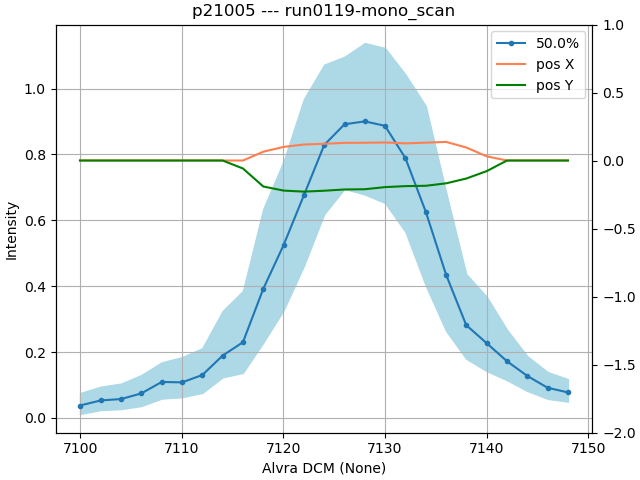

In [34]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax2 = ax1.twinx()
plt.title(titlestring)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

l1 = ax1.plot(Energy_eV, Int_110, label='{}%'.format(quantile_band*100),marker='.')
ax1.fill_between(Energy_eV, err_low_110, err_high_110, color='lightblue')

l2 = ax2.plot(Energy_eV, mean_X, color = 'coral', label='pos X')
l3 = ax2.plot(Energy_eV, mean_Y, color = 'green', label='pos Y')

#ax1.plot(Energy_eV, Int_122, label='monochromator {}%'.format(quantile_band*100),marker='.')
#ax1.fill_between(Energy_eV, err_low_122, err_high_122, color='lightblue')

#ax2.plot(energy_vonHamos, spectrum_vonHamos, label='von Hamos', color = 'coral')
#ax2.set_xlim(3000, 3050)

leg = l1+l2+l3
labels = [l.get_label() for l in leg]

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel("Intensity")
ax2.set_ylim(-2,1)
ax1.legend(leg, labels, loc='best')
#ax2.legend(loc="upper left")

ax1.grid()

plt.show()

#plt.savefig(savedir+'/spectrum_compare.png')

In [35]:
spectrum_toFit = np.copy(Izero_110_norm[:,0])
Energy_eV_toFit = np.copy(Energy_eV)

fit = Fit(gaussian, estimate_gaussian_parameters)

fit.estimate(Energy_eV_toFit, spectrum_toFit)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Energy_eV_toFit,spectrum_toFit)                  # calculate the fit
spectrum_fit = fit.eval(Energy_eV_toFit)            # evaluate the curve for plotting

center = fit.popt[0]
width = fit.popt[2]*2.355

#index = ~(np.isnan(Energy_eV_toFit) | np.isnan(spectrum_toFit))

print("Center wavelength =",np.round(center,3),"eV")
print("Width =",np.abs(np.round(width,3)),"eV")
print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))

#best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)

Center wavelength = 7127.578 eV
Width = 15.752 eV
Bandwidth = 0.22100073825919547 %


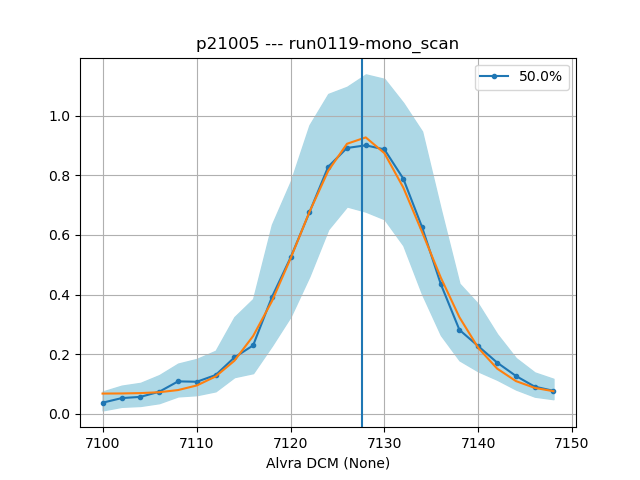

Center wavelength = 7127.578 eV
Width = 15.752 eV
Bandwidth = 0.22100073825919547 %


In [36]:
plt.figure()

plt.plot(Energy_eV, Int_110, label='{}%'.format(quantile_band*100),marker='.')
plt.fill_between(Energy_eV, err_low_110, err_high_110, color='lightblue')

plt.plot(Energy_eV_toFit, spectrum_fit)

plt.title(titlestring)
plt.grid()
plt.xlabel("{} ({})".format(label, units))
plt.legend(loc="best")

plt.axvline(x=center)

plt.show()

print("Center wavelength =",np.round(center,3),"eV")
print("Width =",np.abs(np.round(width,3)),"eV")
print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))


# Overlay different spectra

In [35]:
pgroup='p20775'
#runlist = np.arange(172, 176, 1)
runlist = [6, 8, 164]
Loaddir = '../Claudio/Reduced_monoscans/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 3 runs: [6, 8, 164] from ../Claudio/Reduced_monoscans/


['../Claudio/Reduced_monoscans/run0008-run0006-monoscan_2500eV/run_array.npy',
 '../Claudio/Reduced_monoscans/run0008-run0006-monoscan_2500eV/run_array.npy',
 '../Claudio/Reduced_monoscans/run0164-monoscan_2466eV/run_array.npy']

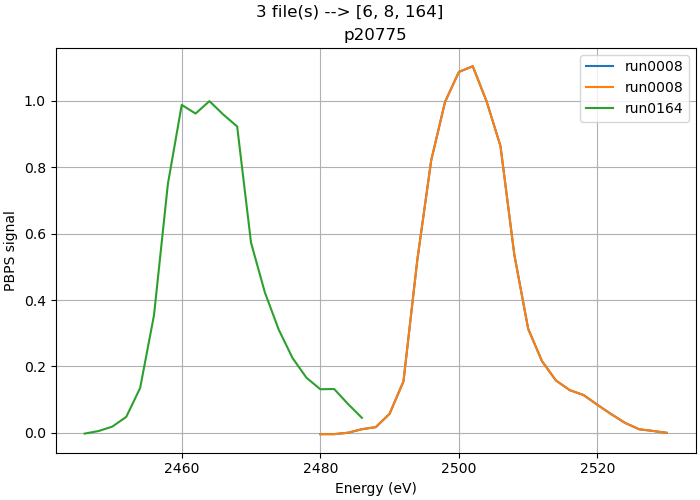

In [34]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        S110 = run_array[key]["Izero110"]
        
        Int_110 = S110[:,0]
        
        ax1.plot(Energy_eV, S110[:,0], label=runnumber)
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
        
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("PBPS signal")
ax1.legend()
ax1.grid()

ax1.set_title(pgroup)

plt.show()

In [29]:
7.5217 - 7.5016

0.02010000000000023

In [82]:
import matplotlib.dates
from datetime import datetime

x_values = [datetime(2021, 5, 3), datetime(2021, 5, 6), datetime(2021, 5, 15), 
            datetime(2021, 11, 13), datetime(2021, 11, 30), datetime(2022, 5, 9),
            datetime(2022, 9, 11), datetime(2022, 9, 20), datetime(2022, 10, 10),
            datetime(2022, 10, 15), datetime(2022, 10, 25),datetime(2023, 1, 26), 
            datetime(2023, 1, 30), datetime(2023, 2, 27)]

y_values = [0.33, 0.32, 0.31, 0.25, 0.29, 0.34, 0.64, 0.53, 0.41, 0.45, 0.41, 0.44, 0.38, 0.48]

dates = matplotlib.dates.date2num(x_values)

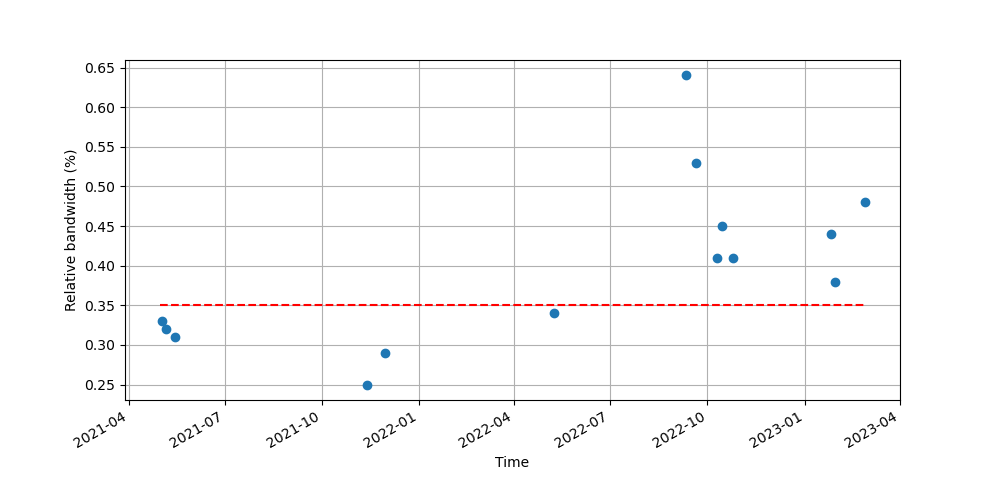

In [83]:
plt.figure(figsize=(10,5))
plt.plot_date(dates, y_values)
plt.gcf().autofmt_xdate()
plt.ylabel('Relative bandwidth (%)')
plt.xlabel('Time')
plt.hlines(0.35, datetime(2021, 5, 1), datetime(2023, 2, 27), linestyles='dashed', color = 'red')
plt.grid()
plt.show()